In [1]:
# !pip install pandas
# !pip install imbalanced-learn
# !pip install seaborn
# !pip install graphviz
# !pip install sklearn
# !pip install xgboost
# !pip install numpy
# !pip install stopwords

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import re
import nltk
# nltk.download('stopwords')
# stemmer = nltk.SnowballStemmer("english")
import string
import csv

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics, svm, tree, preprocessing
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics._plot.roc_curve import plot_roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_selection import RFECV, SelectFromModel
from numpy import mean
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# %matplotlib inline
# pd.set_option('display.max_colwidth', 1000)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/carolkkw/CIND820_Project/main/data/streaming_imdb2.csv", sep =',', index_col=0)

df.head(3)

,type,title,genre,certificate,country,imdb_rating,date_added,year_added,release_year,service_name
1,Movie,Dick Johnson Is Dead,"Biography,Documentary,Drama",Teens,United States,7.4,2021-09-25,2021,2020,Netflix
9,Movie,Sankofa,Drama,Adult,"United States, Ghana, Burkina Faso, United Kin...",7.0,2021-09-24,2021,1993,Netflix
11,Movie,The Starling,"Comedy,Drama",Teens,United States,6.3,2021-09-24,2021,2021,Netflix


In [3]:
#lables, uniques = pd.factorize(df["certificate"])
#uniques
#df["certificate_num"] = pd.factorize(df["certificate"])[0]
#df.groupby(["certificate","certificate_num"]).size().reset_index().rename(columns={0:"count"}).sort_values("certificate_num")


In [4]:
#lables, uniques = pd.factorize(df["type"])
#uniques
#df["type_num"] = pd.factorize(df["type"])[0]
#df.groupby(["type","type_num"]).size().reset_index().rename(columns={0:"count"}).sort_values("type_num")


In [5]:
df.head(3)

,type,title,genre,certificate,country,imdb_rating,date_added,year_added,release_year,service_name
1,Movie,Dick Johnson Is Dead,"Biography,Documentary,Drama",Teens,United States,7.4,2021-09-25,2021,2020,Netflix
9,Movie,Sankofa,Drama,Adult,"United States, Ghana, Burkina Faso, United Kin...",7.0,2021-09-24,2021,1993,Netflix
11,Movie,The Starling,"Comedy,Drama",Teens,United States,6.3,2021-09-24,2021,2021,Netflix


In [6]:
df.isna().sum()

type            0
title           0
genre           0
certificate     0
country         0
imdb_rating     0
date_added      0
year_added      0
release_year    0
service_name    0
dtype: int64

In [7]:
# convert object to numeric values so that we  can use the .fit function

encorder = preprocessing.LabelEncoder()

df["certificate_num"] = encorder.fit_transform(df['certificate'])
df["type_num"] = encorder.fit_transform(df['type'])

In [8]:
# drop service_name attribute first
df1 = df.drop(columns = ["service_name"])

# get correlation
corr = df1.corr()
corr

,imdb_rating,year_added,release_year,certificate_num,type_num
imdb_rating,1.000000,-0.056458,-0.076070,-0.006988,0.264658
year_added,-0.056458,1.000000,0.045387,0.110431,-0.098976
release_year,-0.076070,0.045387,1.000000,-0.093618,0.131447
certificate_num,-0.006988,0.110431,-0.093618,1.000000,-0.148577
type_num,0.264658,-0.098976,0.131447,-0.148577,1.000000


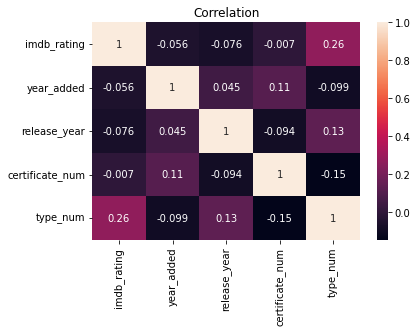

In [9]:
# visualization of correlation

hm = sns.heatmap(df1.corr(), annot = True)

hm.set(title = "Correlation")

plt.show()

In [10]:
df1 = df[["imdb_rating","year_added","release_year","certificate_num","type_num","service_name"]]
df1.head(3)

,imdb_rating,year_added,release_year,certificate_num,type_num,service_name
1,7.4,2021,2020,6,0,Netflix
9,7.0,2021,1993,0,0,Netflix
11,6.3,2021,2021,6,0,Netflix


Check skewness along the index axis

In [11]:
df1.skew(axis = 0, skipna = True)

/var/folders/jf/_4751svx72v36w_0fc5s0_880000gn/T/ipykernel_11484/1229944174.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1.skew(axis = 0, skipna = True)


imdb_rating       -0.526444
year_added        -1.347455
release_year      -3.257559
certificate_num    0.036116
type_num           1.116294
dtype: float64

normalize data

In [12]:
df_num = df1[["imdb_rating","year_added","release_year","certificate_num","type_num"]]
df_normalize = df_num.apply(lambda x:(x-x.min()) / (x.max()-x.min()))
df_normalize = df_normalize.join(df1['service_name'])
df_normalize.head()


,imdb_rating,year_added,release_year,certificate_num,type_num,service_name
1,0.711111,1.0,0.989247,1.0,0.0,Netflix
9,0.666667,1.0,0.698925,0.0,0.0,Netflix
11,0.588889,1.0,1.000000,1.0,0.0,Netflix
14,0.488889,1.0,1.000000,0.0,0.0,Netflix
27,0.600000,1.0,0.752688,1.0,0.0,Netflix


check if the numeric attributes are normalized

In [13]:
df_normalize.describe()

,imdb_rating,year_added,release_year,certificate_num,type_num
count,9062.000000,9062.000000,9062.000000,9062.000000,9062.000000
mean,0.613074,0.839804,0.901067,0.497315,0.256345
std,0.133922,0.126164,0.133842,0.420637,0.436639
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.533333,0.769231,0.881720,0.000000,0.000000
50%,0.622222,0.846154,0.946237,0.500000,0.000000
75%,0.711111,0.923077,0.967742,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


divide dataset to training and testing

In [14]:
x = df_normalize[df_normalize.columns[:-1]]
y = df_normalize['service_name']

#scale the data (feature scaling)
sc = StandardScaler()
x = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify=y)

In [15]:
y_test.value_counts()

Netflix    1947
Hulu        444
Disney      324
Amazon        4
Name: service_name, dtype: int64

prepare SMOTE to handle imbalance data

In [16]:
sm = SMOTE(sampling_strategy='minority',random_state=42)
x_sm, y_sm = sm.fit_resample(x_train, y_train)

check ROSE and see the different between SMOTE

In [17]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

check samples

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((6343, 5), (6343,), (2719, 5), (2719,))

In [19]:
# SMOTE new count
y_sm.value_counts()

Netflix    4543
Amazon     4543
Hulu       1035
Disney      757
Name: service_name, dtype: int64

In [20]:
# ROSE new count
y_ros.value_counts()

Netflix    4543
Amazon     4543
Hulu       1035
Disney      757
Name: service_name, dtype: int64

In [21]:
# original count
y_test.value_counts()

Netflix    1947
Hulu        444
Disney      324
Amazon        4
Name: service_name, dtype: int64

In [22]:
# check the normalize
for df_normalize in [y_train, y_test]:
    print(df_normalize.describe())

count        6343
unique          4
top       Netflix
freq         4543
Name: service_name, dtype: object
count        2719
unique          4
top       Netflix
freq         1947
Name: service_name, dtype: object


Without Cross Validation

Maximum accuracy: 0.7844795880838543 at K = 10


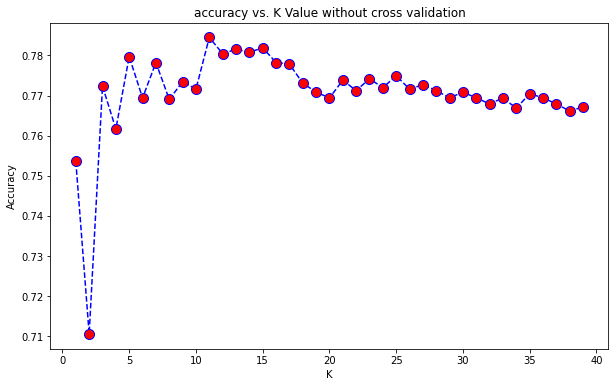

In [23]:
# Optimal k value with max accuracy without cross validation
acc = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    yhat = neigh.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value without cross validation')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)))

Minimum error: 0.21552041191614565 at K = 10


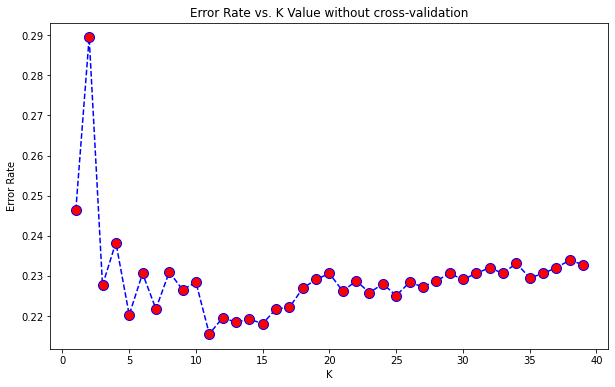

In [24]:
# get optimal k value with minmimum error without cross validation
error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(x_train,y_train)
 pred_i = knn.predict(x_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value without cross-validation')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum F1 Score: 0.7700681897343327 at K = 4


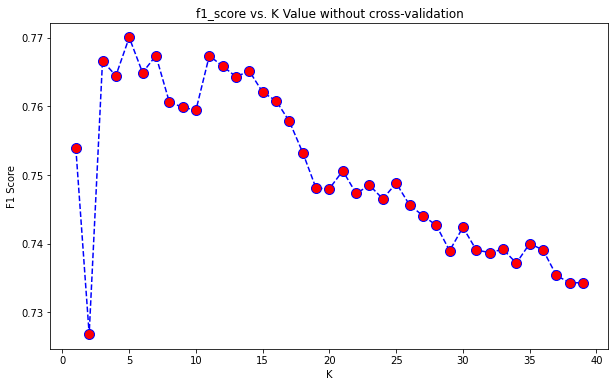

In [25]:
# get optimal k value with maximum F1 Score without cross validation
acc = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(x_train,y_train)
    yhat = neigh.predict(x_test)
    acc.append(metrics.f1_score(y_test, yhat, average = 'weighted'))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('f1_score vs. K Value without cross-validation')
plt.xlabel('K')
plt.ylabel('F1 Score')
print("Maximum F1 Score:",max(acc),"at K =",acc.index(max(acc)))

Cross Validation: 

Goal - to find the optimal value of cv

Ideal: 0.769
> folds=4, accuracy=0.765 (0.752,0.773)
> folds=5, accuracy=0.768 (0.756,0.778)
> folds=6, accuracy=0.765 (0.756,0.778)
> folds=7, accuracy=0.766 (0.748,0.778)
> folds=8, accuracy=0.770 (0.757,0.779)


/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=9.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=11.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=12.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=13.
  warnings.warn(
/opt/homebrew/lib/python3.9/sit

> folds=9, accuracy=0.768 (0.748,0.790)
> folds=10, accuracy=0.768 (0.752,0.784)
> folds=11, accuracy=0.770 (0.742,0.793)
> folds=12, accuracy=0.769 (0.748,0.790)
> folds=13, accuracy=0.769 (0.738,0.789)
> folds=14, accuracy=0.767 (0.735,0.801)
> folds=15, accuracy=0.768 (0.745,0.787)
> folds=16, accuracy=0.767 (0.743,0.791)
> folds=17, accuracy=0.770 (0.732,0.804)
> folds=18, accuracy=0.770 (0.722,0.805)


/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=15.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=16.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=17.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=18.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=19.
  warnings.warn(


> folds=19, accuracy=0.769 (0.737,0.796)


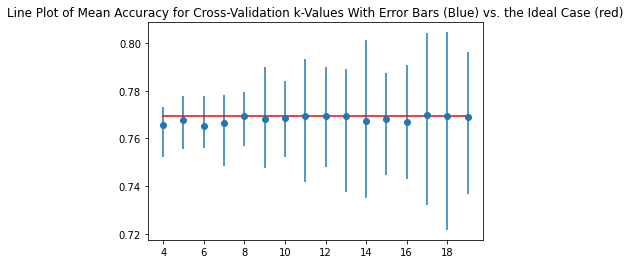

In [26]:
# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the model
	model = KNeighborsClassifier()
	# evaluate the model
	scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()
 
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)

# define folds to test
folds = range(4,20)

# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)

plt.title('Line Plot of Mean Accuracy for Cross-Validation k-Values With Error Bars (Blue) vs. the Ideal Case (red)')
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

Cross-validation:

Goal - to find the optimal value of K based on F1 Score that is good evaludation for imbalanced data

/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/si

Maximum F1_weighted: 0.7612559129797811 at K = 6


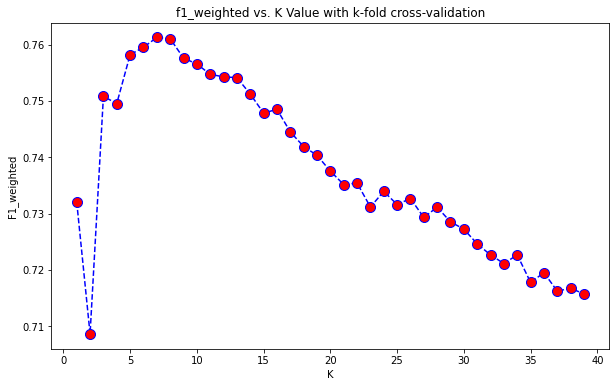

In [27]:
# get optimal k value with better f1_weighted using 10-fold cross-validation suggested above 

acc = []
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)

for i in range(1,40):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, x_train, y_train, cv = cv, scoring = 'f1_weighted')
    acc.append(scores.mean())
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('f1_weighted vs. K Value with k-fold cross-validation')
plt.xlabel('K')
plt.ylabel('F1_weighted')
print("Maximum F1_weighted:",max(acc),"at K =",acc.index(max(acc)))

/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/lib/python3.9/si

Maximum accuracy: 0.7764462604634988 at K = 12


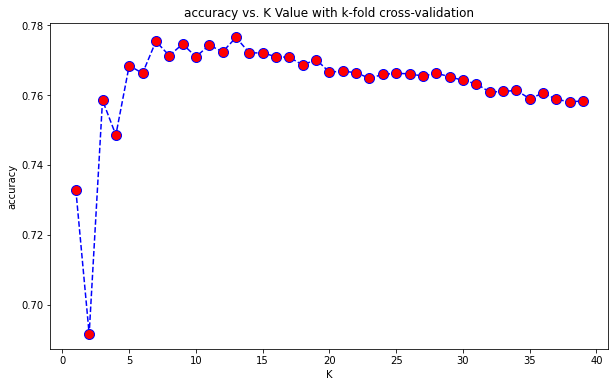

In [28]:
# get optimal k value with better accuracy using 10-fold cross-validation suggested above 

acc = []
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)

for i in range(1,40):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, x_train, y_train, cv = cv, scoring = 'accuracy')
    acc.append(scores.mean())
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value with k-fold cross-validation')
plt.xlabel('K')
plt.ylabel('accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)))

Cross-validation: Model Selection

Cross-validation in KNN Model

In [29]:
# Normal
knn = KNeighborsClassifier(n_neighbors = 6)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',knn)])
knn_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, knn_pred))
print(classification_report(y, knn_pred))
print("roc_auc:", cross_val_score(pipe,  x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_knn = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_knn['test_score'].mean())
print("fit time:", cv_results_knn['fit_time'].mean())
print("score time:", cv_results_knn['score_time'].mean())


[[   0    3    2    7]
 [   0  683   57  341]
 [   0   86  627  766]
 [   0  302  489 5699]]
              precision    recall  f1-score   support

      Amazon       0.00      0.00      0.00        12
      Disney       0.64      0.63      0.63      1081
        Hulu       0.53      0.42      0.47      1479
     Netflix       0.84      0.88      0.86      6490

    accuracy                           0.77      9062
   macro avg       0.50      0.48      0.49      9062
weighted avg       0.76      0.77      0.77      9062

roc_auc: 0.7567526749230791


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test score: 0.7734512778950083
fit time: 0.004734849929809571
score time: 0.010408234596252442


In [30]:
# SMOTE
knn = KNeighborsClassifier(n_neighbors = 6)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',SMOTE(random_state=42)), ('model',knn)])
knn_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, knn_pred))
print(classification_report(y, knn_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_knn = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_knn['test_score'].mean())
print("fit time:", cv_results_knn['fit_time'].mean())
print("score time:", cv_results_knn['score_time'].mean())


[[   5    2    2    3]
 [  35  842  107   97]
 [  14  179  981  305]
 [  92  740 1440 4218]]
              precision    recall  f1-score   support

      Amazon       0.03      0.42      0.06        12
      Disney       0.48      0.78      0.59      1081
        Hulu       0.39      0.66      0.49      1479
     Netflix       0.91      0.65      0.76      6490

    accuracy                           0.67      9062
   macro avg       0.45      0.63      0.48      9062
weighted avg       0.77      0.67      0.69      9062

roc_auc: 0.8025436930568777
test score: 0.6671845907839687
fit time: 0.03192591667175293
score time: 0.011041593551635743


In [31]:
# ROSE
knn = KNeighborsClassifier(n_neighbors = 6)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',RandomOverSampler(random_state=42)), ('model',knn)])
knn_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, knn_pred))
print(classification_report(y, knn_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_knn = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_knn['test_score'].mean())
print("fit time:", cv_results_knn['fit_time'].mean())
print("score time:", cv_results_knn['score_time'].mean())


[[   1    6    2    3]
 [   6  850  136   89]
 [   4  183  981  311]
 [  15  762 1600 4113]]
              precision    recall  f1-score   support

      Amazon       0.04      0.08      0.05        12
      Disney       0.47      0.79      0.59      1081
        Hulu       0.36      0.66      0.47      1479
     Netflix       0.91      0.63      0.75      6490

    accuracy                           0.66      9062
   macro avg       0.45      0.54      0.46      9062
weighted avg       0.77      0.66      0.68      9062

roc_auc: 0.746304026805033
test score: 0.6560386349973593
fit time: 0.020770764350891112
score time: 0.010562586784362792


Cross-validation in Logistic Regression Model



In [32]:
# Normal
logreg = LogisticRegression(random_state=42, solver="lbfgs", max_iter=1000)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',logreg)])
logreg_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, logreg_pred))
print(classification_report(y, logreg_pred))

print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_logreg = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_logreg['test_score'].mean())
print("fit time:", cv_results_logreg['fit_time'].mean())
print("score time:", cv_results_logreg['score_time'].mean())

[[   0    1    0   11]
 [   0  163   24  894]
 [   0   39  393 1047]
 [   0  112  391 5987]]
              precision    recall  f1-score   support

      Amazon       0.00      0.00      0.00        12
      Disney       0.52      0.15      0.23      1081
        Hulu       0.49      0.27      0.34      1479
     Netflix       0.75      0.92      0.83      6490

    accuracy                           0.72      9062
   macro avg       0.44      0.33      0.35      9062
weighted avg       0.68      0.72      0.68      9062



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


roc_auc: 0.7798011841657043
test score: 0.7220269865724279
fit time: 0.03817265033721924
score time: 0.0003875017166137695


In [33]:
# SMOTE
logreg = LogisticRegression(random_state=42, solver="lbfgs", max_iter=1000)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',SMOTE(random_state=42)),('model',logreg)])
logreg_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, logreg_pred))
print(classification_report(y, logreg_pred))

print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_logreg = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_logreg['test_score'].mean())
print("fit time:", cv_results_logreg['fit_time'].mean())
print("score time:", cv_results_logreg['score_time'].mean())

[[   9    2    1    0]
 [ 164  511  142  264]
 [ 155  143  820  361]
 [ 770  829 1820 3071]]
              precision    recall  f1-score   support

      Amazon       0.01      0.75      0.02        12
      Disney       0.34      0.47      0.40      1081
        Hulu       0.29      0.55      0.38      1479
     Netflix       0.83      0.47      0.60      6490

    accuracy                           0.49      9062
   macro avg       0.37      0.56      0.35      9062
weighted avg       0.68      0.49      0.54      9062

roc_auc: 0.8307199927429506
test score: 0.4867633636834919
fit time: 0.1570295810699463
score time: 0.0008397579193115234


In [34]:
# ROSE
logreg = LogisticRegression(random_state=42, solver="lbfgs", max_iter=1000)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',RandomOverSampler(random_state=42)),('model',logreg)])
logreg_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, logreg_pred))
print(classification_report(y, logreg_pred))

print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_logreg = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_logreg['test_score'].mean())
print("fit time:", cv_results_logreg['fit_time'].mean())
print("score time:", cv_results_logreg['score_time'].mean())

[[  10    2    0    0]
 [ 166  492  138  285]
 [ 157  139  779  404]
 [ 789  762 1751 3188]]
              precision    recall  f1-score   support

      Amazon       0.01      0.83      0.02        12
      Disney       0.35      0.46      0.40      1081
        Hulu       0.29      0.53      0.38      1479
     Netflix       0.82      0.49      0.62      6490

    accuracy                           0.49      9062
   macro avg       0.37      0.58      0.35      9062
weighted avg       0.68      0.49      0.55      9062

roc_auc: 0.8323667996152257
test score: 0.49316257414127546
fit time: 0.12047932147979737
score time: 0.0007708549499511718


Cross-valiation in Naive Bayes Model

In [35]:
'''# Normal
# cannot use multinominal Naive Bayes as negative value is not allowed
naibay = MultinomialNB()
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([ ('model',naibay)])
naibay_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, naibay_pred))
print(classification_report(y, naibay_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_naibay = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_naibay['test_score'].mean())
print("fit time:", cv_results_naibay['fit_time'].mean())
print("score time:", cv_results_naibay['score_time'].mean())'''

'# Normal\n# cannot use multinominal Naive Bayes as negative value is not allowed\nnaibay = MultinomialNB()\ncv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)\npipe = Pipeline([ (\'model\',naibay)])\nnaibay_pred = cross_val_predict(pipe, x, y, cv = cv)\n\nprint(confusion_matrix(y, naibay_pred))\nprint(classification_report(y, naibay_pred))\nprint("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring=\'roc_auc_ovo\').mean())\n\n# Evaludate the efficiency\ncv_results_naibay = cross_validate(pipe, x, y, cv=cv)\n\nprint("test score:", cv_results_naibay[\'test_score\'].mean())\nprint("fit time:", cv_results_naibay[\'fit_time\'].mean())\nprint("score time:", cv_results_naibay[\'score_time\'].mean())'

Cross-valiation in Random Forest Model

In [36]:
# Normal
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[   0    3    1    8]
 [   0  690   83  308]
 [   1   88  672  718]
 [   3  259  513 5715]]
              precision    recall  f1-score   support

      Amazon       0.00      0.00      0.00        12
      Disney       0.66      0.64      0.65      1081
        Hulu       0.53      0.45      0.49      1479
     Netflix       0.85      0.88      0.86      6490

    accuracy                           0.78      9062
   macro avg       0.51      0.49      0.50      9062
weighted avg       0.77      0.78      0.78      9062

roc_auc: 0.8056322133274024
test score: 0.7809547278829609
fit time: 0.32245216369628904
score time: 0.013683462142944336


In [37]:
# SMOTE
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',SMOTE(random_state=42)), ('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[   3    3    1    5]
 [  18  744   92  227]
 [   4  105  758  612]
 [  24  359  718 5389]]
              precision    recall  f1-score   support

      Amazon       0.06      0.25      0.10        12
      Disney       0.61      0.69      0.65      1081
        Hulu       0.48      0.51      0.50      1479
     Netflix       0.86      0.83      0.85      6490

    accuracy                           0.76      9062
   macro avg       0.51      0.57      0.52      9062
weighted avg       0.77      0.76      0.77      9062

roc_auc: 0.8413680261884771
test score: 0.7607599465525675
fit time: 1.3765745401382445
score time: 0.015421724319458008


In [38]:
# ROSE
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',RandomOverSampler(random_state=42)), ('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[   1    3    3    5]
 [   1  745  105  230]
 [   2  110  770  597]
 [   5  396  877 5212]]
              precision    recall  f1-score   support

      Amazon       0.11      0.08      0.10        12
      Disney       0.59      0.69      0.64      1081
        Hulu       0.44      0.52      0.48      1479
     Netflix       0.86      0.80      0.83      6490

    accuracy                           0.74      9062
   macro avg       0.50      0.52      0.51      9062
weighted avg       0.76      0.74      0.75      9062

roc_auc: 0.7915194910729757
test score: 0.7424430052254845
fit time: 0.7148479223251343
score time: 0.014410257339477539


In [39]:
# SMOTE, SelectFromModel
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
sfm = SelectFromModel(estimator=ranfor)
pipe = Pipeline([('over',SMOTE(random_state=42)), ('sfm',sfm), ('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[   3    5    2    2]
 [   4  793   75  209]
 [   4   86  623  766]
 [ 150  469  704 5167]]
              precision    recall  f1-score   support

      Amazon       0.02      0.25      0.03        12
      Disney       0.59      0.73      0.65      1081
        Hulu       0.44      0.42      0.43      1479
     Netflix       0.84      0.80      0.82      6490

    accuracy                           0.73      9062
   macro avg       0.47      0.55      0.48      9062
weighted avg       0.74      0.73      0.73      9062

roc_auc: 0.8406565763467683
test score: 0.7267742186720405
fit time: 2.245896816253662
score time: 0.02152254581451416


In [40]:
# SMOTE, RFECV
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
rfecv = RFECV(estimator=ranfor, cv=cv, scoring='f1_weighted')
pipe = Pipeline([('over',RandomOverSampler(random_state=42)), ('rfecv',rfecv), ('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[   1    3    3    5]
 [   1  745  105  230]
 [   2  110  770  597]
 [   5  396  877 5212]]
              precision    recall  f1-score   support

      Amazon       0.11      0.08      0.10        12
      Disney       0.59      0.69      0.64      1081
        Hulu       0.44      0.52      0.48      1479
     Netflix       0.86      0.80      0.83      6490

    accuracy                           0.74      9062
   macro avg       0.50      0.52      0.51      9062
weighted avg       0.76      0.74      0.75      9062

roc_auc: 0.7915194910729757
test score: 0.7424430052254845
fit time: 29.833912014961243
score time: 0.015037202835083007


Cross-valiation in Decision Tree Model

In [41]:
# Normal
dectre = tree.DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',dectre)])
dectre_scores = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, dectre_scores))
print(classification_report(y, dectre_scores))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_dectre = cross_validate(pipe, x, y,cv=cv)

print("test score:", cv_results_dectre['test_score'].mean())
print("fit time:", cv_results_dectre['fit_time'].mean())
print("score time:", cv_results_dectre['score_time'].mean())

[[   1    3    1    7]
 [   3  693  100  285]
 [   1  107  708  663]
 [   7  365  764 5354]]
              precision    recall  f1-score   support

      Amazon       0.08      0.08      0.08        12
      Disney       0.59      0.64      0.62      1081
        Hulu       0.45      0.48      0.46      1479
     Netflix       0.85      0.82      0.84      6490

    accuracy                           0.75      9062
   macro avg       0.49      0.51      0.50      9062
weighted avg       0.75      0.75      0.75      9062

roc_auc: 0.6721124553437554
test score: 0.745531565868606
fit time: 0.011173248291015625
score time: 0.0005541324615478515


In [42]:
# SMOTE
dectre = tree.DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',SMOTE(random_state=42)), ('model',dectre)])
dectre_scores = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, dectre_scores))
print(classification_report(y, dectre_scores))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_dectre = cross_validate(pipe, x, y,cv=cv)

print("test score:", cv_results_dectre['test_score'].mean())
print("fit time:", cv_results_dectre['fit_time'].mean())
print("score time:", cv_results_dectre['score_time'].mean())

[[   2    3    1    6]
 [  11  704  103  263]
 [   4  125  703  647]
 [  24  414  841 5211]]
              precision    recall  f1-score   support

      Amazon       0.05      0.17      0.08        12
      Disney       0.57      0.65      0.61      1081
        Hulu       0.43      0.48      0.45      1479
     Netflix       0.85      0.80      0.83      6490

    accuracy                           0.73      9062
   macro avg       0.47      0.52      0.49      9062
weighted avg       0.75      0.73      0.74      9062

roc_auc: 0.6872186186437378
test score: 0.7305255177415783
fit time: 0.07154765129089355
score time: 0.0005299806594848633


In [43]:
# ROSE
dectre = tree.DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('over',RandomOverSampler(random_state=42)), ('model',dectre)])
dectre_scores = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, dectre_scores))
print(classification_report(y, dectre_scores))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_dectre = cross_validate(pipe, x, y,cv=cv)

print("test score:", cv_results_dectre['test_score'].mean())
print("fit time:", cv_results_dectre['fit_time'].mean())
print("score time:", cv_results_dectre['score_time'].mean())

[[   1    2    2    7]
 [   2  702  106  271]
 [   2  105  708  664]
 [   5  401  914 5170]]
              precision    recall  f1-score   support

      Amazon       0.10      0.08      0.09        12
      Disney       0.58      0.65      0.61      1081
        Hulu       0.41      0.48      0.44      1479
     Netflix       0.85      0.80      0.82      6490

    accuracy                           0.73      9062
   macro avg       0.48      0.50      0.49      9062
weighted avg       0.74      0.73      0.73      9062

roc_auc: 0.6707079121983203
test score: 0.7262225856777432
fit time: 0.03348979949951172
score time: 0.00047986507415771485


In [44]:
# find optimal depth
depth = []
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
parameters = [{'max_depth':range(3,50)}]
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=cv, n_jobs=-1)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
tree.plot_tree


0.79794886959654 {'max_depth': 9}


<function sklearn.tree._export.plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False, precision=3, ax=None, fontsize=None)>

According the result above, Random Forest is better model. New input will be used in Random Forest to predict class.

In [45]:
new_input = np.array([[10.0, 2023, 2023, 0, 0],
                      [10.0, 2023, 2023, 1, 0],
                      [10.0, 2023, 2023, 2, 0],
                      [10.0, 2023, 2023, 3, 0],
                      [10.0, 2023, 2023, 4, 0],
                      [10.0, 2023, 2023, 5, 0],
                      [10.0, 2023, 2023, 6, 0],

                      [10.0, 2023, 2023, 0, 1],
                      [10.0, 2023, 2023, 1, 1],
                      [10.0, 2023, 2023, 2, 1],
                      [10.0, 2023, 2023, 3, 1],
                      [10.0, 2023, 2023, 4, 1],
                      [10.0, 2023, 2023, 5, 1],
                      [10.0, 2023, 2023, 6, 1],

                      [10.0, 2024, 2024, 0, 0],
                      [10.0, 2024, 2024, 1, 0],
                      [10.0, 2024, 2024, 2, 0],
                      [10.0, 2024, 2024, 3, 0],
                      [10.0, 2024, 2024, 4, 0],
                      [10.0, 2024, 2024, 5, 0],
                      [10.0, 2024, 2024, 6, 0],

                      [10.0, 2024, 2024, 0, 1],
                      [10.0, 2024, 2024, 1, 1],
                      [10.0, 2024, 2024, 2, 1],
                      [10.0, 2024, 2024, 3, 1],
                      [10.0, 2024, 2024, 4, 1],
                      [10.0, 2024, 2024, 5, 1],
                      [10.0, 2024, 2024, 6, 1],

                      [10.0, 2027, 2027, 0, 0],
                      [10.0, 2027, 2027, 1, 0],
                      [10.0, 2027, 2027, 2, 0],
                      [10.0, 2027, 2027, 3, 0],
                      [10.0, 2027, 2027, 4, 0],
                      [10.0, 2027, 2027, 5, 0],
                      [10.0, 2027, 2027, 6, 0],

                      ])

new_table = pd.DataFrame(new_input, columns = ["imdb_rating","year_added","release_year","certificate_num","type_num"])
new_table.head(3)

,imdb_rating,year_added,release_year,certificate_num,type_num
0,10.0,2023.0,2023.0,0.0,0.0
1,10.0,2023.0,2023.0,1.0,0.0
2,10.0,2023.0,2023.0,2.0,0.0


In [46]:
# apply new data to Random Forest

ranfor = RandomForestClassifier(random_state=42)
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x, y)
ranfor.fit(x_sm, y_sm)
new_output = ranfor.predict(new_table)
new_pred = new_table
new_pred['predict'] = pd.DataFrame(new_output, columns=['predict'])
print(new_pred)

    imdb_rating  year_added  release_year  certificate_num  type_num  predict
0          10.0      2023.0        2023.0              0.0       0.0  Netflix
1          10.0      2023.0        2023.0              1.0       0.0  Netflix
2          10.0      2023.0        2023.0              2.0       0.0  Netflix
3          10.0      2023.0        2023.0              3.0       0.0  Netflix
4          10.0      2023.0        2023.0              4.0       0.0  Netflix
5          10.0      2023.0        2023.0              5.0       0.0  Netflix
6          10.0      2023.0        2023.0              6.0       0.0  Netflix
7          10.0      2023.0        2023.0              0.0       1.0  Netflix
8          10.0      2023.0        2023.0              1.0       1.0  Netflix
9          10.0      2023.0        2023.0              2.0       1.0  Netflix
10         10.0      2023.0        2023.0              3.0       1.0  Netflix
11         10.0      2023.0        2023.0              4.0      

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [47]:
# check if it is because Netflix does not have other certificate so that Amazon is leading
df.groupby(["certificate","certificate_num","service_name"]).size().reset_index().rename(columns={0:"count"}).sort_values("service_name")

,certificate,certificate_num,service_name,count
0,Adult,0,Amazon,3
18,Teens,6,Amazon,1
9,Parental Guidance,3,Amazon,7
6,No Rating,2,Amazon,1
19,Teens,6,Disney,122
15,Suitable For All,5,Disney,241
10,Parental Guidance,3,Disney,308
3,Kids,1,Disney,410
7,No Rating,2,Hulu,1
4,Kids,1,Hulu,240


In [48]:
# take away certificate_num
new_input2 = np.array([[10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],
                      [10.0, 2023, 2023, 0],

                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],
                      [10.0, 2023, 2023, 1],

                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],
                      [10.0, 2027, 2027, 0],

                      ])

new_table2 = pd.DataFrame(new_input2, columns = ["imdb_rating","year_added","release_year","type_num"])
new_table2.head(3)

,imdb_rating,year_added,release_year,type_num
0,10.0,2023.0,2023.0,0.0
1,10.0,2023.0,2023.0,0.0
2,10.0,2023.0,2023.0,0.0


In [49]:
# remove certificate to see if it is impact

# train the data without certificate_num
#x = df_normalize[df_normalize.columns[:-1]]
#y = df_normalize['service_name']

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify=y)

x_train2 = pd.DataFrame(x_train, columns = ["imdb_rating","year_added","release_year","certificate_num","type_num"])
sm = SMOTE(sampling_strategy='minority',random_state=42)
x_sm2, y_sm2 = sm.fit_resample(x_train2, y_train)
x_sm2 = x_sm2.drop("certificate_num", axis=1)

# fit into Random Forest Classifier
ranfor = RandomForestClassifier(random_state=42)
ranfor.fit(x_sm2, y_sm2)

# predict class using new input
new_output2 = ranfor.predict(new_table2)
new_pred2 = new_table2
new_pred2['predict'] = pd.DataFrame(new_output2, columns=['predict'])
print(new_pred2)

    imdb_rating  year_added  release_year  type_num  predict
0          10.0      2023.0        2023.0       0.0  Netflix
1          10.0      2023.0        2023.0       0.0  Netflix
2          10.0      2023.0        2023.0       0.0  Netflix
3          10.0      2023.0        2023.0       0.0  Netflix
4          10.0      2023.0        2023.0       0.0  Netflix
5          10.0      2023.0        2023.0       0.0  Netflix
6          10.0      2023.0        2023.0       0.0  Netflix
7          10.0      2023.0        2023.0       1.0  Netflix
8          10.0      2023.0        2023.0       1.0  Netflix
9          10.0      2023.0        2023.0       1.0  Netflix
10         10.0      2023.0        2023.0       1.0  Netflix
11         10.0      2023.0        2023.0       1.0  Netflix
12         10.0      2023.0        2023.0       1.0  Netflix
13         10.0      2023.0        2023.0       1.0  Netflix
14         10.0      2027.0        2027.0       0.0  Netflix
15         10.0      202


Evaluate Genre using model

In [50]:
encorder = preprocessing.LabelEncoder()

# get a dataframe with individual genre
b = df[["title","type","year_added","genre","service_name"]]
#this function is to separate genres to rows

# convert listed of genres to rows, vertically stack to a dataframe
b = pd.DataFrame(df.genre.str.split(',').tolist(), index=[df.title, df.year_added, df.service_name]).stack()
b = b.reset_index()[[0, 'title','year_added','service_name']]
b.columns = ['genre', 'title','year_added','service_name']  # rename columns
b2 = b.groupby(['year_added','genre','service_name']).genre.agg(['count']).rename(columns={'count':'num_of_show'}).reset_index()
b2 = b2[["year_added","genre","num_of_show","service_name"]]

print(b2)

     year_added      genre  num_of_show service_name
0          2008  Adventure            1         Hulu
1          2008     Comedy            2         Hulu
2          2008      Drama            1         Hulu
3          2008     Family            2         Hulu
4          2009     Action            7         Hulu
..          ...        ...          ...          ...
529        2021   Thriller          111      Netflix
530        2021        War            1         Hulu
531        2021        War            9      Netflix
532        2021    Western            2         Hulu
533        2021    Western            5      Netflix

[534 rows x 4 columns]


In [51]:
# put genre in numeric so that we can apply into model
#lables, uniques = pd.factorize(b2["genre"])
#lables
#b2["genre_num"] = pd.factorize(b2["genre"])[0]
#b2.groupby(["genre","genre_num"]).size().reset_index().rename(columns={0:"count"}).sort_values("genre_num")


In [52]:
b2['genre'] = encorder.fit_transform(b2['genre'])

In [53]:
b2.isna().sum()

year_added      0
genre           0
num_of_show     0
service_name    0
dtype: int64

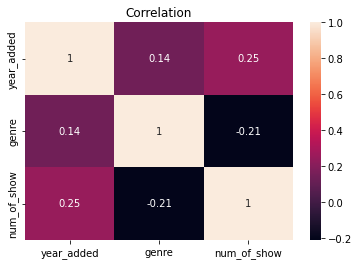

In [54]:
# visualization of correlation
 
hm_b2 = sns.heatmap(b2.corr(), annot = True)
 
hm_b2.set(title = "Correlation")
 
plt.show()

<AxesSubplot:>

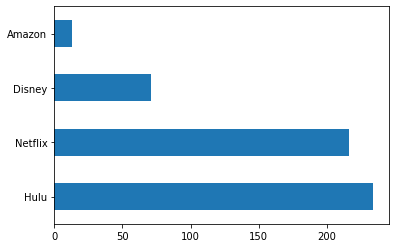

In [55]:
# check if data is imbalanced or not
b2['service_name'].value_counts().plot(kind='barh')
    

In [56]:
b2 = b2[["year_added","genre","num_of_show","service_name"]]
b3 = b2[["year_added","genre","num_of_show"]]

b2_normalize = b3.apply(lambda x:(x-x.min()) / (x.max()-x.min()))
b2_normalize = b2_normalize.join(b2['service_name'])
b2_normalize.head()

,year_added,genre,num_of_show,service_name
0,0.000000,0.074074,0.000000,Hulu
1,0.000000,0.185185,0.001422,Hulu
2,0.000000,0.296296,0.000000,Hulu
3,0.000000,0.333333,0.001422,Hulu
4,0.076923,0.000000,0.008535,Hulu


In [57]:
b2_normalize.describe()

,year_added,genre,num_of_show
count,534.000000,534.000000,534.000000
mean,0.709306,0.469483,0.051846
std,0.250712,0.298291,0.113473
min,0.000000,0.000000,0.000000
25%,0.538462,0.222222,0.001422
50%,0.769231,0.444444,0.011380
75%,0.923077,0.740741,0.048364
max,1.000000,1.000000,1.000000


In [58]:
# prepare data and target
x_genre = b2_normalize.drop(columns=['service_name','num_of_show'])
y_genre = b2_normalize['service_name']

#scale the data (feature scaling)
sc = StandardScaler()
x_genre = sc.fit_transform(x_genre)

x_train, x_test, y_train, y_test = train_test_split(x_genre, y_genre, test_size = 0.3, random_state = 42, stratify=y_genre)

In [59]:
# SMOTE
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x_genre, y_genre)

In [60]:
# new input to predict class
new_input3 = np.array([[2023,0],
                       [2023,1],
                       [2023,2],
                       [2023,3],
                       [2023,4],
                       [2023,5],
                       [2023,6],
                       [2023,7],
                       [2023,8],
                       [2023,9],
                       [2023,10],
                       [2023,11],
                       [2023,12],
                       [2023,13],
                       [2023,14],
                       [2023,15],
                       [2023,16],
                       [2023,17],
                       [2023,18],
                       [2023,19],
                       [2023,20],
                       [2023,21],
                       [2023,22],
                       [2023,23],
                       [2023,24],
                       [2023,25],
                       [2023,26],
                       [2023,27],

                       [2024,0],
                       [2024,1],
                       [2024,2],
                       [2024,3],
                       [2024,4],
                       [2024,5],
                       [2024,6],
                       [2024,7],

                       [2027,10],
                       [2027,11],
                       [2027,12],
                       [2027,13],
                       [2027,14],
                       [2027,15],

                      ])

new_table3 = pd.DataFrame(new_input3, columns = ["year_added","genre"])
new_table3.head()

,year_added,genre
0,2023,0
1,2023,1
2,2023,2
3,2023,3
4,2023,4


In [61]:
# predict class using genre
ranfor = RandomForestClassifier(random_state=42)
ranfor.fit(x_sm, y_sm)
new_output3 = ranfor.predict(new_table3)
new_pred3 = new_table3
new_pred3['predict'] = pd.DataFrame(new_output3, columns=['predict'])
print(new_pred3)

    year_added  genre  predict
0         2023      0   Amazon
1         2023      1   Amazon
2         2023      2  Netflix
3         2023      3  Netflix
4         2023      4  Netflix
5         2023      5  Netflix
6         2023      6  Netflix
7         2023      7  Netflix
8         2023      8  Netflix
9         2023      9  Netflix
10        2023     10  Netflix
11        2023     11  Netflix
12        2023     12  Netflix
13        2023     13  Netflix
14        2023     14  Netflix
15        2023     15  Netflix
16        2023     16  Netflix
17        2023     17  Netflix
18        2023     18  Netflix
19        2023     19  Netflix
20        2023     20  Netflix
21        2023     21  Netflix
22        2023     22  Netflix
23        2023     23  Netflix
24        2023     24  Netflix
25        2023     25  Netflix
26        2023     26  Netflix
27        2023     27  Netflix
28        2024      0   Amazon
29        2024      1   Amazon
30        2024      2  Netflix
31      

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Evaluate Country to predict class

In [62]:
encorder = preprocessing.LabelEncoder()
 
# get a dataframe with individual genre
bcountry = df[["year_added","country","service_name"]]
#this function is to separate genres to rows
 
# convert listed of genres to rows, vertically stack to a dataframe
bcountry = pd.DataFrame(df.country.str.split(',').tolist(), index=[df.year_added, df.service_name]).stack()
bcountry = bcountry.reset_index()[[0, 'year_added','service_name']]
bcountry.columns = ['country','year_added','service_name']  # rename columns
bcountry2 = bcountry.groupby(['year_added','country','service_name']).country.agg(['count']).rename(columns={'count':'num_of_show'}).reset_index()
bcountry2 = bcountry2[["year_added","country","num_of_show","service_name"]]
print(bcountry2)

     year_added        country  num_of_show service_name
0          2008  United States            2         Hulu
1          2009        Denmark            1      Netflix
2          2009          Japan            7         Hulu
3          2009  United States            1      Netflix
4          2010          Japan            8         Hulu
..          ...            ...          ...          ...
921        2021  United States            7       Amazon
922        2021  United States          177       Disney
923        2021  United States          211         Hulu
924        2021  United States          516      Netflix
925        2021        Vietnam            2      Netflix

[926 rows x 4 columns]


In [63]:
# put genre in numeric so that we can apply into model
#lables, uniques = pd.factorize(b2["country"])
#lables
#b2["country_num"] = pd.factorize(b2["country"])[0]
#b2.groupby(["country","country_num"]).size().reset_index().rename(columns={0:"count"}).sort_values("country_num")


In [64]:
bcountry2['country'] = encorder.fit_transform(bcountry2['country'])

In [65]:
bcountry2.isna().sum()

year_added      0
country         0
num_of_show     0
service_name    0
dtype: int64

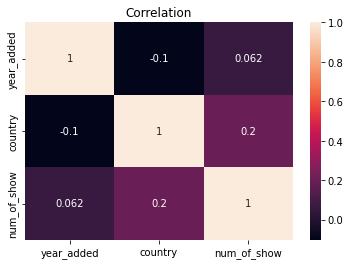

In [66]:
# visualization of correlation
hm_bcountry2 = sns.heatmap(bcountry2.corr(), annot = True)
hm_bcountry2.set(title = "Correlation")
plt.show()

<AxesSubplot:>

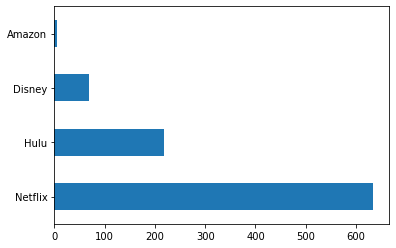

In [67]:
# check if data is imbalanced or not
bcountry2['service_name'].value_counts().plot(kind='barh')

In [68]:
# normalize country
bcountry2 = bcountry2[["year_added","country","num_of_show","service_name"]]
bcountry3 = bcountry2[["year_added","country","num_of_show"]]
 
bcountry2_normalize = bcountry3.apply(lambda x:(x-x.min()) / (x.max()-x.min()))
bcountry2_normalize = bcountry2_normalize.join(bcountry2['service_name'])
bcountry2_normalize.head()

,year_added,country,num_of_show,service_name
0,0.000000,0.978723,0.001458,Hulu
1,0.076923,0.664894,0.000000,Netflix
2,0.076923,0.760638,0.008746,Hulu
3,0.076923,0.978723,0.000000,Netflix
4,0.153846,0.760638,0.010204,Hulu


In [69]:
bcountry2_normalize.describe()

,year_added,country,num_of_show
count,926.000000,926.000000,926.000000
mean,0.800881,0.540376,0.016838
std,0.168724,0.290249,0.072914
min,0.000000,0.000000,0.000000
25%,0.692308,0.260638,0.000000
50%,0.846154,0.550532,0.001458
75%,0.923077,0.765957,0.008746
max,1.000000,1.000000,1.000000


In [70]:
# prepare data and target
x_country = b2_normalize.drop(columns=['service_name','num_of_show'])
y_country = b2_normalize['service_name']
 
#scale the data (feature scaling)
sc = StandardScaler()
x_country = sc.fit_transform(x_country)
 
x_train, x_test, y_train, y_test = train_test_split(x_country, y_country, test_size = 0.3, random_state = 42, stratify=y_country)

In [71]:
# SMOTE
sm = RandomOverSampler(random_state=42)
x_sm_country, y_sm_country = sm.fit_resample(x_country, y_country)

In [72]:
# new input to predict class
new_input4 = np.array([[2023,0],
                       [2023,1],
                       [2023,2],
                       [2023,3],
                       [2023,4],
                       [2023,5],
                       [2023,6],
                       [2023,7],
                       [2023,8],
                       [2023,9],
                       [2023,10],
                       [2023,11],
                       [2023,12],
                       [2023,13],
                       [2023,14],
                       [2023,15],
                       [2023,16],
                       [2023,17],
                       [2023,18],
                       [2023,19],
                       [2023,20],
                       [2023,21],
                       [2023,22],
                       [2023,23],
                       [2023,24],
                       [2023,25],
                       [2023,26],
                       [2023,27],

                       [2024,0],
                       [2024,1],
                       [2024,2],
                       [2024,3],
                       [2024,4],
                       [2024,5],
                       [2024,6],
                       [2024,7],

                       [2027,10],
                       [2027,11],
                       [2027,12],
                       [2027,13],
                       [2027,14],
                       [2027,15],

                      ])

new_table4 = pd.DataFrame(new_input4, columns = ["year_added","country"])
new_table4.head()

,year_added,country
0,2023,0
1,2023,1
2,2023,2
3,2023,3
4,2023,4


In [73]:
# predict class using genre
ranfor = RandomForestClassifier(random_state=42)
ranfor.fit(x_sm_country, y_sm_country)
new_output4 = ranfor.predict(new_table4)
new_pred4 = new_table4
new_pred4['predict'] = pd.DataFrame(new_output4, columns=['predict'])
print(new_pred4)

    year_added  country  predict
0         2023        0   Disney
1         2023        1   Disney
2         2023        2  Netflix
3         2023        3  Netflix
4         2023        4  Netflix
5         2023        5  Netflix
6         2023        6  Netflix
7         2023        7  Netflix
8         2023        8  Netflix
9         2023        9  Netflix
10        2023       10  Netflix
11        2023       11  Netflix
12        2023       12  Netflix
13        2023       13  Netflix
14        2023       14  Netflix
15        2023       15  Netflix
16        2023       16  Netflix
17        2023       17  Netflix
18        2023       18  Netflix
19        2023       19  Netflix
20        2023       20  Netflix
21        2023       21  Netflix
22        2023       22  Netflix
23        2023       23  Netflix
24        2023       24  Netflix
25        2023       25  Netflix
26        2023       26  Netflix
27        2023       27  Netflix
28        2024        0   Disney
29        

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
